In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.dates import DateFormatter
from scipy.stats import skew
from hmmlearn.hmm import GaussianHMM
import yfinance as yf 
import matplotlib.patches as mpatches

plt.style.use("seaborn-v0_8")

## Add macro & cross-section features

In [2]:
prices=pd.read_csv('data/prices_preprocessed.csv', index_col=0, parse_dates=True)
prices
returns_d = np.log(prices).diff().dropna()

In [3]:
returns_d.index=pd.to_datetime(returns_d.index)

In [4]:
returns_d.shape

(1446, 169)

In [5]:
# daily macro series
yf_tickers = {
    "^VIX":  "VIX",        # implied vol
    "DX-Y.NYB": "USD_Index",  # dollar strength
    "^IRX":  "TBill_13w",  # 3-month Treasury yield
    "^TNX":  "TNote_10y",  # 10-year yield
    "GLD":   "Gold",       # gold ETF
    "USO":   "Oil",        # crude proxy
    "XLK":   "Tech_ETF",   # sector ETFs give risk-on/off flavour
    "XLF":   "Fin_ETF",
    "XLU":   "Util_ETF",
}

macro = ( yf.download(list(yf_tickers), start=returns_d.index[0].date(),
                      end=returns_d.index[-1].date(), interval="1d",
                      progress=False)["Close"]
            .rename(columns=yf_tickers)
            .reindex(returns_d.index).ffill() )

YF.download() has changed argument auto_adjust default to True


In [6]:
macro=pd.read_csv("data/macro_data.csv",index_col=0)
macro.index=pd.to_datetime(macro.index)

In [7]:
macro.head()

,USD_Index,Gold,Oil,Fin_ETF,Tech_ETF,Util_ETF,TBill_13w,TNote_10y,VIX
timestamp,,,,,,,,,
2017-03-08,102.070000,115.059998,85.360001,21.128824,48.304970,38.902790,0.708,2.552,11.86
2017-03-09,101.849998,114.470001,84.239998,21.205751,48.295834,38.818291,0.713,2.598,12.30
2017-03-14,101.699997,114.120003,81.519997,21.180105,48.487816,39.217697,0.753,2.595,12.30
2017-03-20,100.410004,117.510002,82.160004,20.800966,48.995762,39.384174,0.710,2.473,11.34
2017-03-21,99.809998,118.540001,80.879997,20.217684,48.279953,39.941383,0.753,2.436,12.47


In [8]:
# PCA factors on the cross-section of returns
pca  = PCA(n_components=5, random_state=0).fit(returns_d)
pcs  = pd.DataFrame(pca.transform(returns_d), index=returns_d.index,
                    columns=[f"PC{i+1}" for i in range(5)])

In [9]:
pcs

,PC1,PC2,PC3,PC4,PC5
timestamp,,,,,
2017-03-08,0.143307,-0.058202,-0.125741,0.056464,-0.164224
2017-03-09,0.081844,-0.011410,-0.022411,0.044490,-0.054308
2017-03-14,-0.048128,0.024819,-0.036475,-0.006088,0.038816
2017-03-20,-0.239743,-0.056150,-0.121984,-0.057974,0.116695
2017-03-21,0.258823,-0.064403,-0.008320,-0.000251,0.047061
...,...,...,...,...,...
2023-01-05,0.085789,0.175049,0.199836,-0.104313,-0.009722
2023-01-06,-0.250921,0.029338,0.049289,-0.102146,0.031580
2023-01-09,-0.299659,-0.152523,-0.122080,0.018139,-0.037100


In [10]:
# cross-sectional features
disp = returns_d.std(axis=1).rename("CrossDisp1d")
PctUp        = (returns_d > 0).mean(axis=1).rename("PctUp")
MeanMinusMed = (returns_d.mean(axis=1) - returns_d.median(axis=1)).rename("MeanMinusMed")
AbsDisp      = returns_d.abs().mean(axis=1).rename("AbsDisp")
CSSkew       = returns_d.apply(skew, axis=1).rename("CSSkew")
Top5Share    = ((returns_d.gt(returns_d.quantile(0.95, axis=1), axis=0).sum(axis=1) /returns_d.shape[1]).rename("Top5Share"))

In [11]:
features_d = pd.concat([macro,pcs, PctUp, MeanMinusMed, AbsDisp, CSSkew, Top5Share],axis=1)

In [12]:
features_d.head()

,USD_Index,Gold,Oil,Fin_ETF,Tech_ETF,Util_ETF,TBill_13w,TNote_10y,VIX,PC1,PC2,PC3,PC4,PC5,PctUp,MeanMinusMed,AbsDisp,CSSkew,Top5Share
timestamp,,,,,,,,,,,,,,,,,,,
2017-03-08,102.070000,115.059998,85.360001,21.128824,48.304970,38.902790,0.708,2.552,11.86,0.143307,-0.058202,-0.125741,0.056464,-0.164224,0.248521,-0.005509,0.017783,-1.373010,0.053254
2017-03-09,101.849998,114.470001,84.239998,21.205751,48.295834,38.818291,0.713,2.598,12.30,0.081844,-0.011410,-0.022411,0.044490,-0.054308,0.331361,-0.002279,0.008094,-2.240815,0.053254
2017-03-14,101.699997,114.120003,81.519997,21.180105,48.487816,39.217697,0.753,2.595,12.30,-0.048128,0.024819,-0.036475,-0.006088,0.038816,0.550296,0.000995,0.011137,-2.058412,0.053254
2017-03-20,100.410004,117.510002,82.160004,20.800966,48.995762,39.384174,0.710,2.473,11.34,-0.239743,-0.056150,-0.121984,-0.057974,0.116695,0.810651,0.003189,0.021614,-0.168476,0.053254
2017-03-21,99.809998,118.540001,80.879997,20.217684,48.279953,39.941383,0.753,2.436,12.47,0.258823,-0.064403,-0.008320,-0.000251,0.047061,0.325444,-0.001190,0.017234,0.130642,0.053254


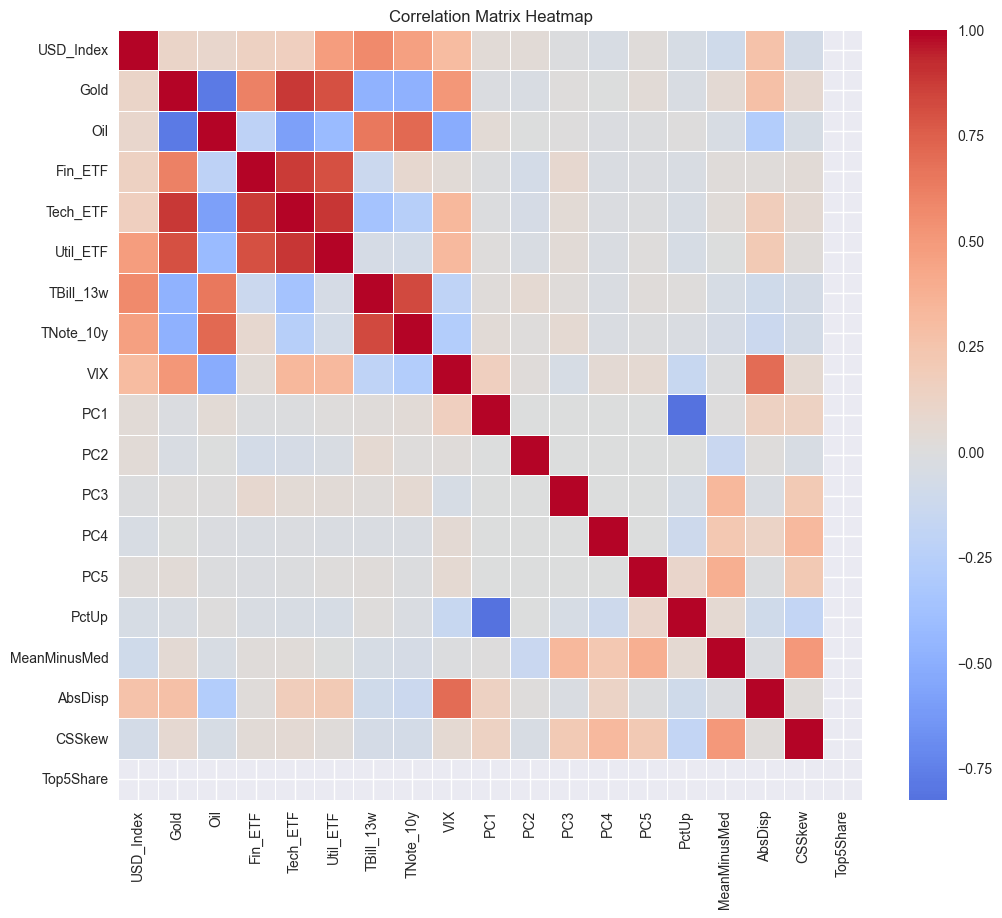

In [13]:
corr_matrix=features_d.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [14]:
# Unstack and filter self-correlations
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Sort by absolute correlation
top_corr = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Display top 20 most correlated pairs
print(top_corr.head(20))

        Feature 1  Feature 2  Correlation
62       Tech_ETF   Util_ETF     0.886274
19           Gold   Tech_ETF     0.880043
48        Fin_ETF   Tech_ETF     0.877378
87      TBill_13w  TNote_10y     0.826297
121           PC1      PctUp    -0.825243
20           Gold   Util_ETF     0.803166
49        Fin_ETF   Util_ETF     0.801467
17           Gold        Oil    -0.780776
37            Oil  TNote_10y     0.714157
115           VIX    AbsDisp     0.699649
36            Oil  TBill_13w     0.648383
18           Gold    Fin_ETF     0.612729
34            Oil   Tech_ETF    -0.588564
5       USD_Index  TBill_13w     0.578257
38            Oil        VIX    -0.517889
23           Gold        VIX     0.509260
151  MeanMinusMed     CSSkew     0.505993
22           Gold  TNote_10y    -0.487113
4       USD_Index   Util_ETF     0.478186
21           Gold  TBill_13w    -0.475902


# EDA Regime Intuition

In [15]:
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 110

/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_43511/4288801577.py:15: UserWarning: Glyph 8333 (\N{SUBSCRIPT LEFT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_43511/4288801577.py:15: UserWarning: Glyph 8334 (\N{SUBSCRIPT RIGHT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/alaabouattour/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8333 (\N{SUBSCRIPT LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/alaabouattour/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8334 (\N{SUBSCRIPT RIGHT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


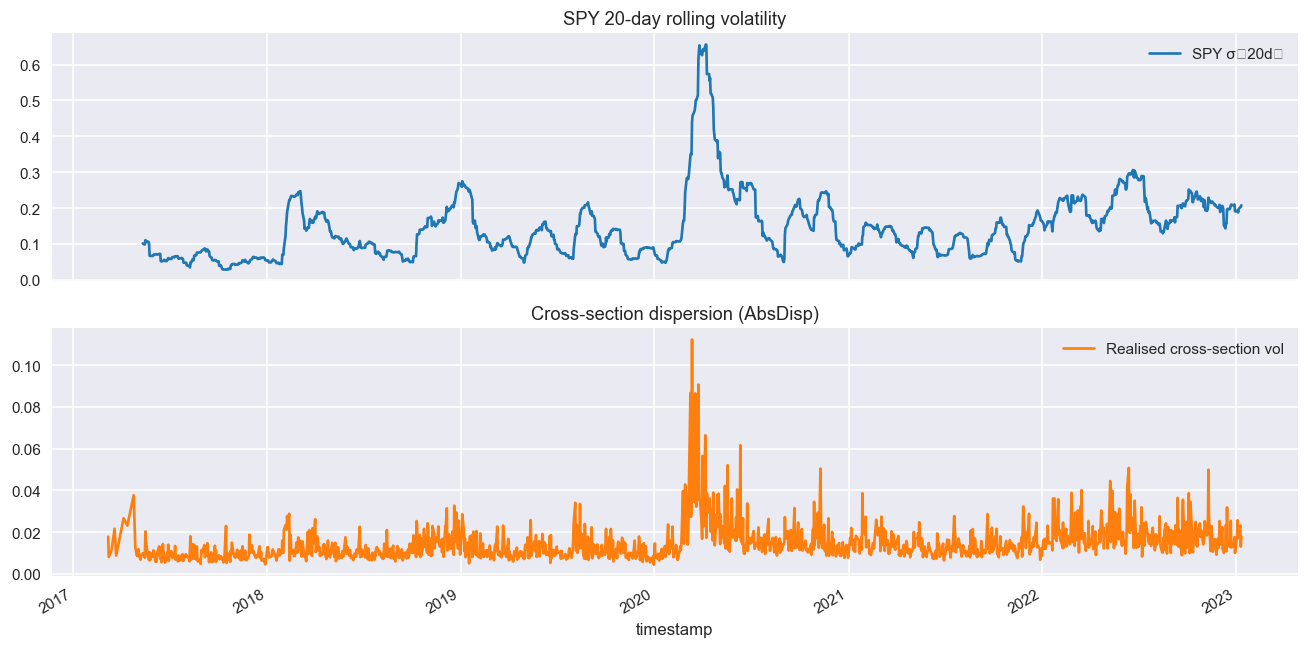

In [16]:
win = 20
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Rolling volatility (annualised)
rolling_vol = returns_d["SPY"].rolling(win).std() * np.sqrt(252)
rolling_vol.plot(ax=ax[0], color="tab:blue", label=f"SPY σ₍{win}d₎")
ax[0].set_title(f"SPY {win}-day rolling volatility")
ax[0].legend()

# Cross-sectional dispersion (AbsDisp)
features_d["AbsDisp"].plot(ax=ax[1], color="tab:orange", label="Realised cross-section vol")
ax[1].set_title("Cross-section dispersion (AbsDisp)")
ax[1].legend()

plt.tight_layout()
plt.show()


The SPY’s 20-day rolling volatility spiked sharply during early 2020, reflecting the COVID-19 market shock.  
This period also saw the highest cross-sectional dispersion, indicating significant divergence in stock returns across the market.


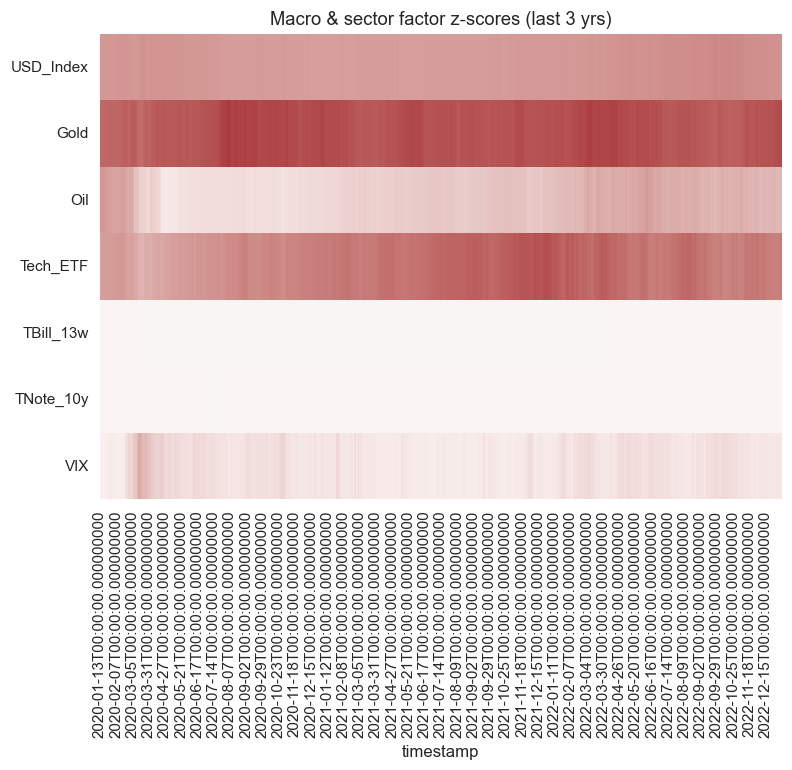

In [17]:
macro_cols = ["USD_Index","Gold","Oil","Tech_ETF","TBill_13w","TNote_10y","VIX"]
macro_last = features_d[macro_cols].tail(3*252)        # ~3 years
sns.heatmap(macro_last.T, cmap="vlag", center=0, cbar=False,
            yticklabels=macro_cols)
plt.title("Macro & sector factor z-scores (last 3 yrs)"); plt.show()


Gold and Tech_ETF show sustained positive z-scores, indicating persistent strength or investor preference.  
In contrast, TBill_13w and TNote_10y remain near zero, suggesting limited variation in recent short and long rates.

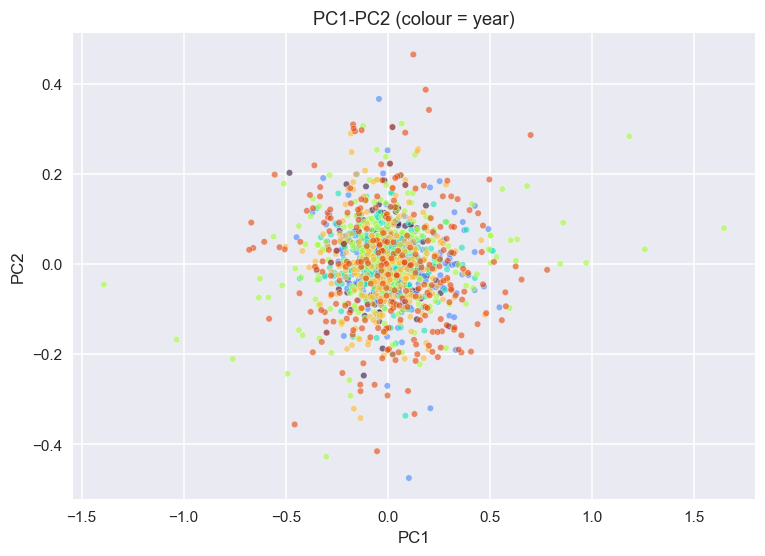

In [18]:
pcs2 = features_d[["PC1","PC2"]].copy()
pcs2["Year"] = pcs2.index.year
sns.scatterplot(data=pcs2, x="PC1", y="PC2", hue="Year",
                palette="turbo", s=18, alpha=.6, legend=False)
plt.title("PC1-PC2 (colour = year)"); plt.show()


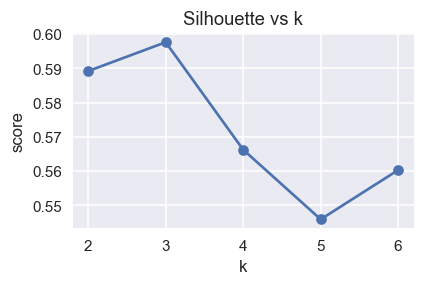

{2: 0.5891913053156073, 3: 0.5976041939058201, 4: 0.566250421201116, 5: 0.5459206608536954, 6: 0.5603085848756414}


In [19]:
X_sil = features_d[["PC1","PC2","AbsDisp","VIX"]].values
scores = {}
for k in range(2,7):
    lab = KMeans(k, n_init=20, random_state=0).fit_predict(X_sil)
    scores[k] = silhouette_score(X_sil, lab)

plt.figure(figsize=(4,2.3))
plt.plot(list(scores), list(scores.values()), marker="o")
plt.title("Silhouette vs k"); plt.xlabel("k"); plt.ylabel("score"); plt.show()
print(scores)

The silhouette analysis suggests that clustering financial regimes into 2 or 3 groups yields the best-defined structure.  
This indicates the presence of distinct market environments (e.g. Bully, Risky, Bear) in the selected factor space.


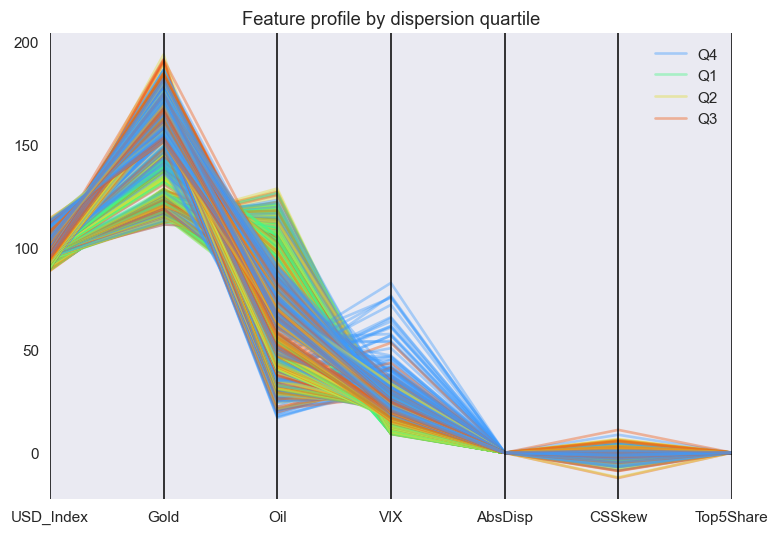

In [20]:
tmp = features_d.copy()
tmp["DispBucket"] = pd.qcut(features_d["AbsDisp"], 4, labels=["Q1","Q2","Q3","Q4"])
plot_cols = ["USD_Index","Gold","Oil","VIX","AbsDisp","CSSkew","Top5Share"]
from pandas.plotting import parallel_coordinates
parallel_coordinates(tmp.reset_index()[["DispBucket"]+plot_cols],
                     "DispBucket",
                     color=sns.color_palette("turbo",4), alpha=.4)
plt.title("Feature profile by dispersion quartile"); plt.show()

The feature profile shows that higher cross-sectional dispersion (Q4) tends to coincide with elevated VIX, Oil, and macro uncertainty.  
As dispersion increases, asymmetry (CSSkew) and concentration (Top5Share) also vary, suggesting shifts in sentiment and leadership dynamics.


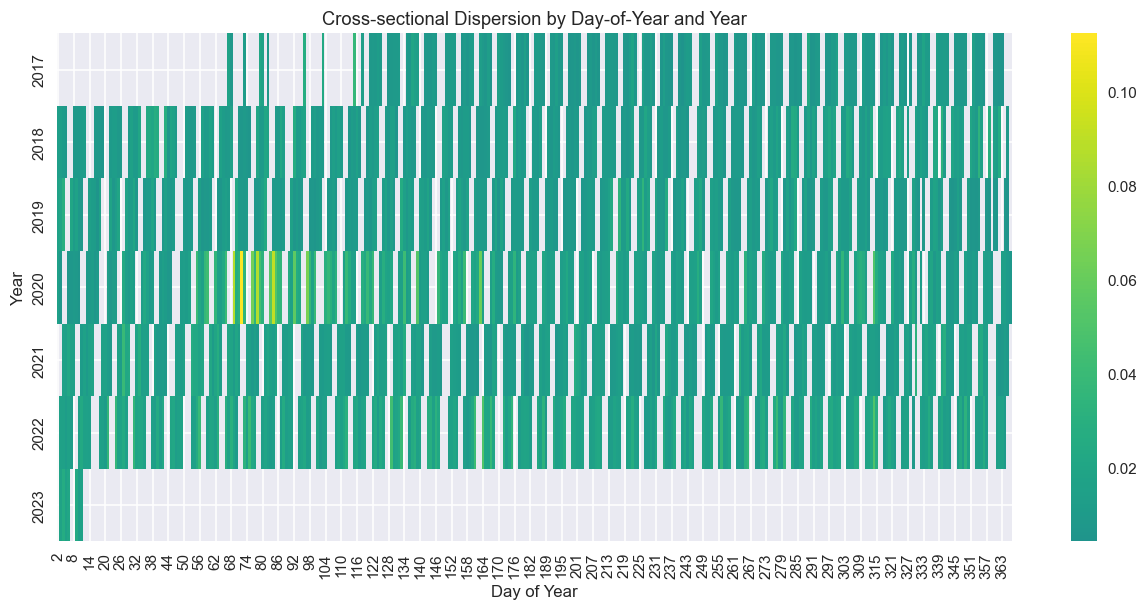

In [21]:
disp = features_d["AbsDisp"].copy()
disp.index = pd.to_datetime(disp.index)

df_disp = disp.to_frame(name="AbsDisp")
pivot = df_disp.pivot_table(values="AbsDisp",index=df_disp.index.year,columns=df_disp.index.dayofyear)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="viridis", center=0)
plt.title("Cross-sectional Dispersion by Day-of-Year and Year")
plt.xlabel("Day of Year")
plt.ylabel("Year")
plt.show()

This heatmap reveals temporal patterns in cross-sectional dispersion across years and calendar days.  
Notably, spikes in 2020 highlight heightened market dislocations (COVID shock), while seasonal dispersion appears relatively stable otherwise.


# Regime Detection

In [22]:
macro=pd.read_csv("data/macro_data.csv",index_col=0)
macro.index=pd.to_datetime(macro.index)

In [23]:
spy ="SPY"

# ---------- 1 · macro series -----------------------------------------------
yf_tickers = [
    "VIX",
    "USD_Index",
    #"TBill_13w",
    #"TNote_10y",
    "Gold",
    "Oil",
    "Tech_ETF",
    #"Fin_ETF",
    #"Util_ETF"
]


macro = macro[yf_tickers]

# ---------- 2 · PCA factors -------------------------------------------------
pca = PCA(n_components=5, random_state=0).fit(returns_d)
pcs = pd.DataFrame(pca.transform(returns_d),
                   index=returns_d.index, columns=[f"PC{i+1}" for i in range(5)])

# ---------- 3 · cross-section metrics --------------------------------------
#disp         = returns_d.std(axis=1).rename("CrossDisp1d")
pct_up       = (returns_d > 0).mean(axis=1).rename("PctUp")
mean_minus   = (returns_d.mean(axis=1) - returns_d.median(axis=1)).rename("MeanMinusMed")
abs_disp     = returns_d.abs().mean(axis=1).rename("AbsDisp")
cs_skew      = returns_d.apply(skew, axis=1).rename("CSSkew")
#top5_share   = (returns_d.gt(returns_d.quantile(0.95, axis=1), axis=0).sum(axis=1).div(returns_d.shape[1]).rename("Top5Share"))
vol20        = returns_d.mean(1).rolling(20).std()
vol_of_vol   = vol20.rolling(20).std().rename("VolOfVol20d")

# ---------- 4 · trend & stress features ------------------------------------
roll_ret20   = returns_d.mean(1).rolling(20).sum().rename("RollRet20d")
vix_div_rv   = (macro["VIX"] / vol20).rename("VIXDivRV")

# ---------- 5 · assemble & drop highly-correlated ---------------------------
features = pd.concat([macro, pcs, disp, pct_up, mean_minus, abs_disp,
                      cs_skew, vol_of_vol, roll_ret20, vix_div_rv],
                     axis=1).dropna()


In [24]:
# auto-drop |ρ| > 0.9
corr = features.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.90)]
features = features.drop(columns=to_drop)
print("Dropped (ρ>0.9):", to_drop)
print("Final feature set:", list(features.columns), "\n")

Dropped (ρ>0.9): ['AbsDisp', 'AbsDisp']
Final feature set: ['VIX', 'USD_Index', 'Gold', 'Oil', 'Tech_ETF', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PctUp', 'MeanMinusMed', 'CSSkew', 'VolOfVol20d', 'RollRet20d', 'VIXDivRV'] 



In [25]:

# ---------- 6 · z-score & fit HMM ------------------------------------------
X = (features - features.mean()) / features.std()

hmm = GaussianHMM(n_components=3, covariance_type="diag",
                  n_iter=1000, tol=1e-3, random_state=42).fit(X)
raw  = pd.Series(hmm.predict(X), index=X.index)

means = pd.DataFrame(hmm.means_, columns=X.columns)


In [26]:
tbl = returns_d[spy].groupby(raw).agg(mean="mean", std="std", days="size")
tbl["sharpe"] = np.sqrt(252)*tbl["mean"]/tbl["std"]
print(tbl, "\n")


         mean       std  days    sharpe
0.0  0.001141  0.004679   450  3.869960
1.0 -0.000621  0.011186   229 -0.880994
2.0  0.000280  0.013409   729  0.331828 



In [27]:
tbl = tbl.sort_values("mean", ascending=False)
print(tbl, "\n")

         mean       std  days    sharpe
0.0  0.001141  0.004679   450  3.869960
2.0  0.000280  0.013409   729  0.331828
1.0 -0.000621  0.011186   229 -0.880994 



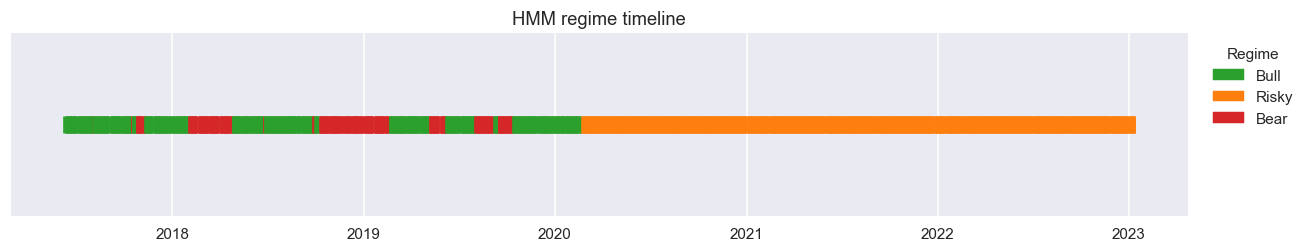

In [28]:
# Step 2: Map state indices to regime names (
mapping = {
    tbl.index[0]: "Bull",     # lowest return
    tbl.index[1]: "Risky",    # middle
    tbl.index[2]: "Bear"      # highest return
}

# Step 3: Apply mapping
regimes = raw.map(mapping).rename("Regime")

# Step 4: Define color map for regimes
color_map = {"Bull": "tab:green", "Risky": "tab:orange", "Bear": "tab:red"}

# Step 5: Plot regime timeline
plt.figure(figsize=(12, 2.4))
plt.scatter(regimes.index, [0]*len(regimes), c=regimes.map(color_map),
            marker="|", s=120)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=handles, title="Regime", loc="upper left", bbox_to_anchor=(1.01, 1))

plt.title("HMM regime timeline")
plt.yticks([])
plt.tight_layout()
plt.show()


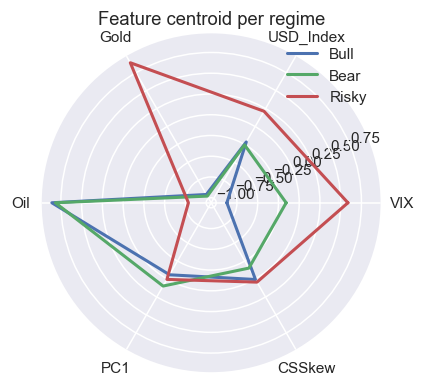

In [29]:
means = pd.DataFrame(hmm.means_, columns=X.columns).assign(Regime=mapping)
plot_cols = ["VIX","USD_Index","Gold","Oil","PC1","CSSkew"]
angles = np.linspace(0, 2*np.pi, len(plot_cols), endpoint=False).tolist()

fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(polar=True)
for _, row in means.iterrows():
    data = row[plot_cols].values
    ax.plot(angles+angles[:1], np.r_[data, data[0]],
            label=row["Regime"], lw=2)
ax.set_xticks(angles); ax.set_xticklabels(plot_cols)
ax.set_title("Feature centroid per regime"); ax.legend(loc="upper right")
plt.show()


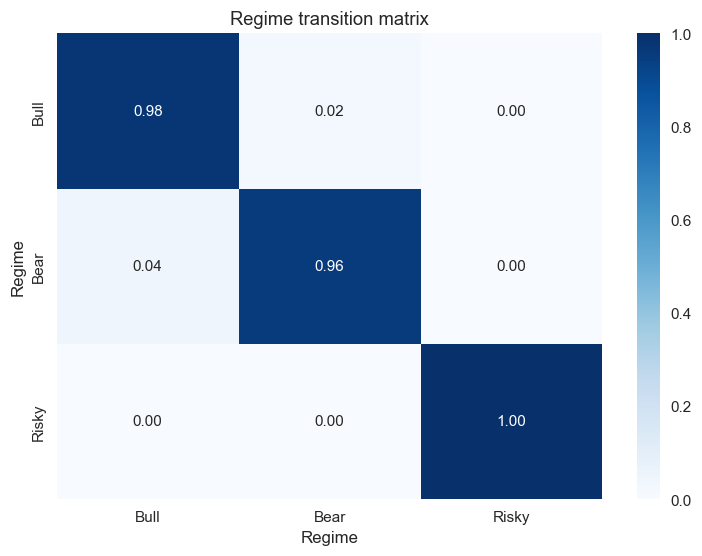

In [30]:
sns.heatmap(pd.DataFrame(hmm.transmat_, index=means["Regime"],
                         columns=means["Regime"]),
            annot=True, cmap="Blues", fmt=".2f")
plt.title("Regime transition matrix"); plt.show()

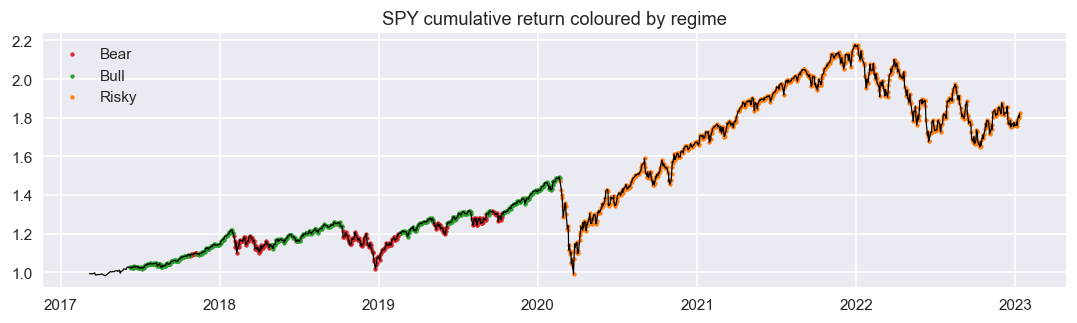

In [ ]:
mkt="SPY"
cum = returns_d[mkt].cumsum().apply(np.exp)
plt.figure(figsize=(12,3))
plt.plot(cum, color="black", lw=.8)
for r, grp in regimes.groupby(regimes):
    plt.scatter(grp.index, cum.loc[grp.index],
                color=color_map[r], s=6, label=r)
plt.title(f"{mkt} cumulative return coloured by regime"); plt.legend(); plt.show()

In [32]:
print("State occupancy (days):\n", regimes.value_counts(), "\n")
print("Mean daily return by regime:")
print(returns_d[mkt].groupby(regimes).agg(["mean","std","count"]))

State occupancy (days):
 Regime
Risky    729
Bull     450
Bear     229
Name: count, dtype: int64 

Mean daily return by regime:
            mean       std  count
Regime                           
Bear   -0.000621  0.011186    229
Bull    0.001141  0.004679    450
Risky   0.000280  0.013409    729


In [33]:
regimes.to_csv("data/regimes.csv")


In [34]:
# to keep them aligned we filter
returns_d.loc[returns_d.index.isin(regimes.index)].to_csv('data/returns.csv')


# Data augmentation

In [35]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

Bear Ep 100/1000 loss=31.8301
Bear Ep 200/1000 loss=23.4897
Bear Ep 300/1000 loss=17.1546
Bear Ep 400/1000 loss=14.5215
Bear Ep 500/1000 loss=12.9408
Bear Ep 600/1000 loss=12.1574
Bear Ep 700/1000 loss=11.0024
Bear Ep 800/1000 loss=11.3136
Bear Ep 900/1000 loss=10.2682
Bear Ep 1000/1000 loss=9.8524


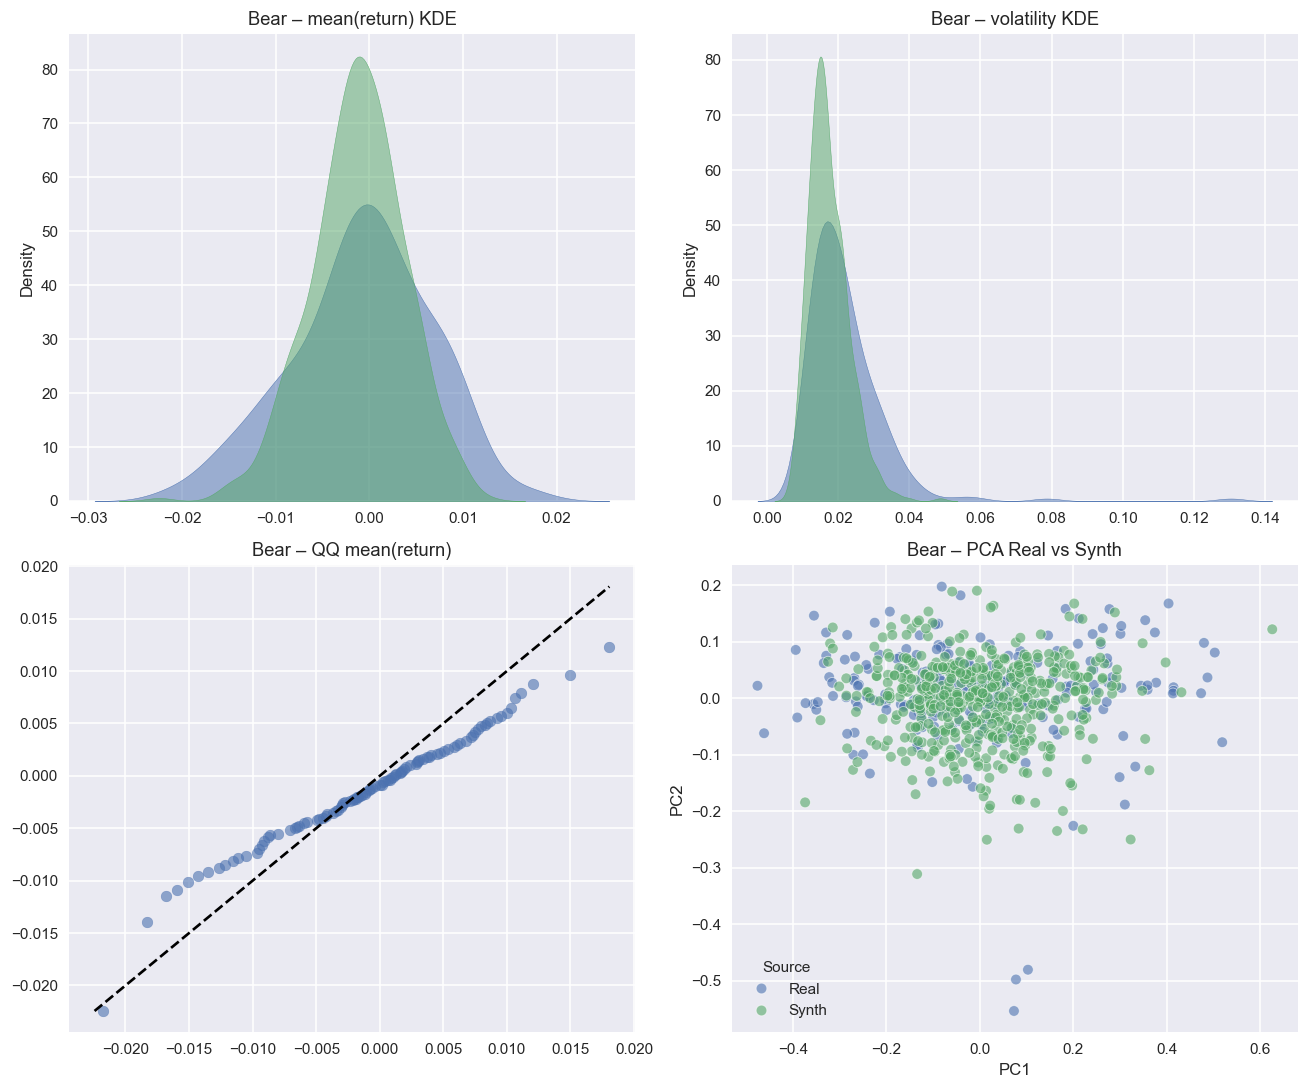

Risky Ep 100/1000 loss=48.0833
Risky Ep 200/1000 loss=39.3829
Risky Ep 300/1000 loss=33.4048
Risky Ep 400/1000 loss=30.5874
Risky Ep 500/1000 loss=30.3223
Risky Ep 600/1000 loss=29.4975
Risky Ep 700/1000 loss=27.1226
Risky Ep 800/1000 loss=26.5055
Risky Ep 900/1000 loss=26.1545
Risky Ep 1000/1000 loss=26.3730


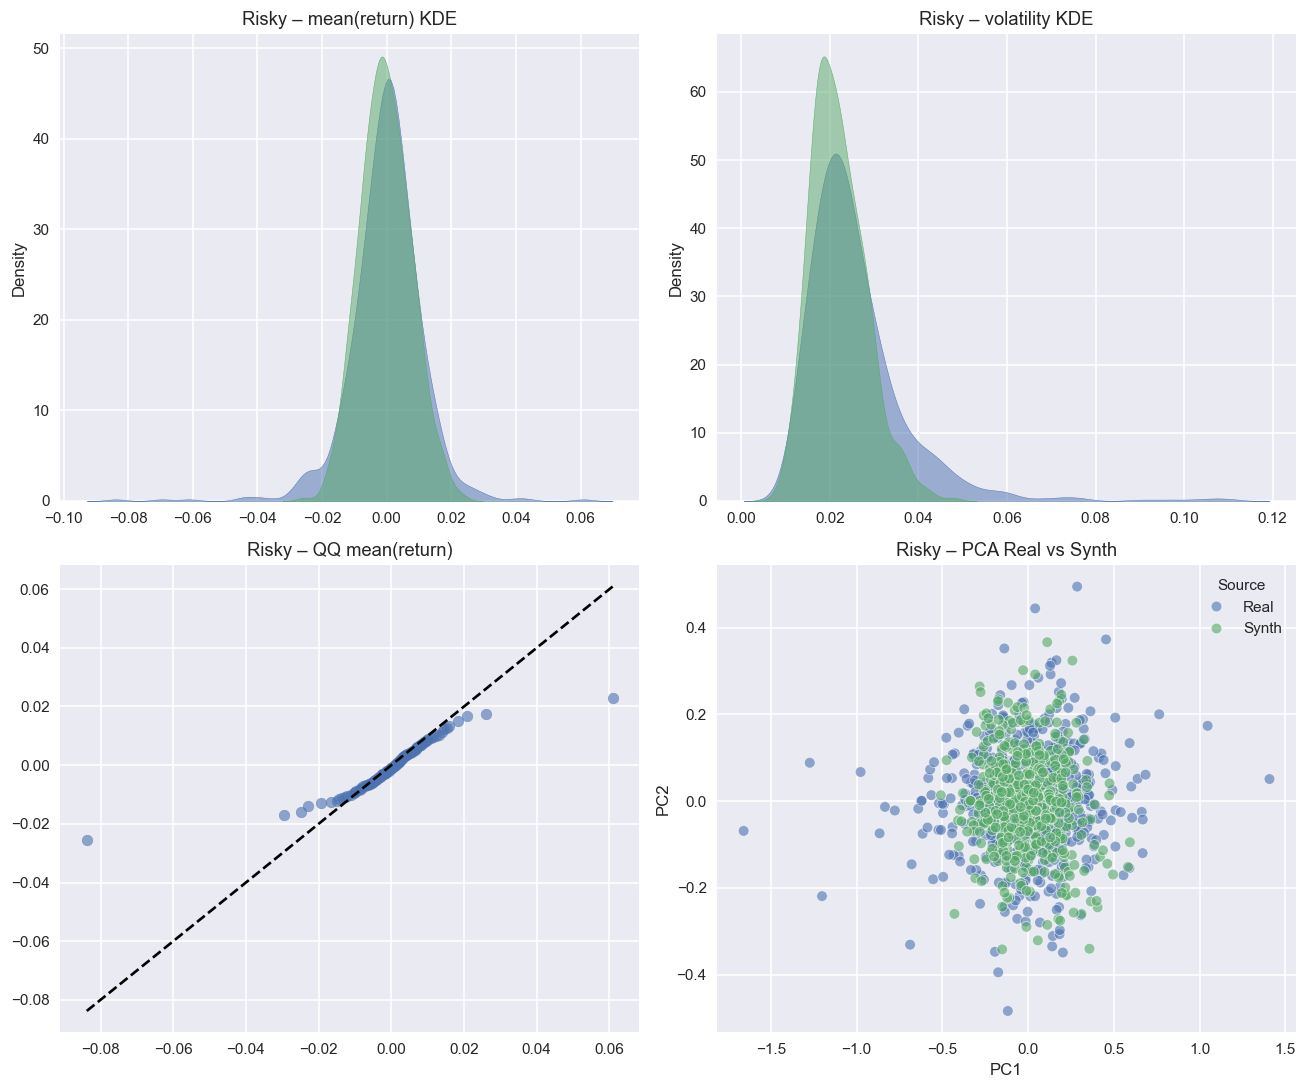

Bull Ep 100/1000 loss=22.1341
Bull Ep 200/1000 loss=17.1219
Bull Ep 300/1000 loss=15.0869
Bull Ep 400/1000 loss=13.9140
Bull Ep 500/1000 loss=13.0937
Bull Ep 600/1000 loss=12.7589
Bull Ep 700/1000 loss=12.3229
Bull Ep 800/1000 loss=12.0436
Bull Ep 900/1000 loss=11.8959
Bull Ep 1000/1000 loss=11.6992


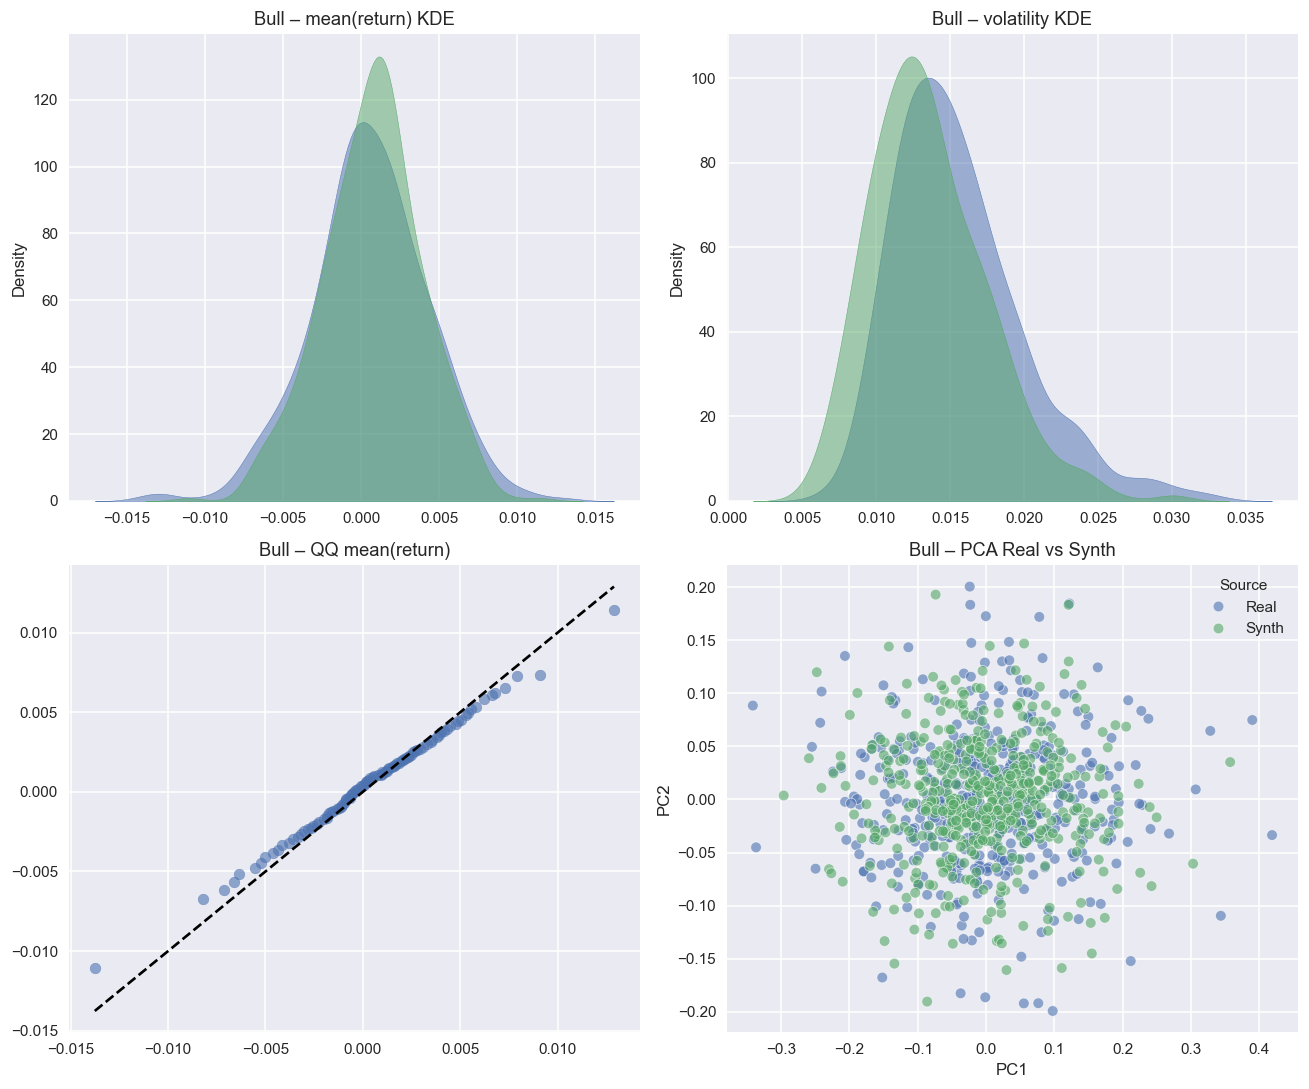

Augmented price panel shape: (2908, 169)


In [36]:
# Load prices & regimes
df = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)

# Scale log-returns for VAE input
scaler = StandardScaler()
returns_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    index=df.index,
    columns=df.columns
)

class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=10, beta=0.2):
        super().__init__()
        self.beta = beta
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu    = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar= nn.Linear(hidden_dim, latent_dim)
        self.dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.out  = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = F.relu(self.enc1(x)); h = F.relu(self.enc2(h))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp(); eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.dec1(z)); h = F.relu(self.dec2(h))
        return self.out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon, x, mu, logvar, beta):
    re  = F.mse_loss(recon, x, reduction='sum')
    kl  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return re + beta * kl

# plotting
def assess_visual(real_df, synth_df, regime_name):
    combined = pd.concat([real_df.assign(Source='Real'),
                          synth_df.assign(Source='Synth')])
    coords = PCA(n_components=2).fit_transform(combined[real_df.columns])
    df_pca = pd.DataFrame(coords, columns=['PC1','PC2'])
    df_pca['Source'] = combined['Source'].values

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    sns.kdeplot(real_df.mean(axis=1), ax=axes[0,0], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.mean(axis=1), ax=axes[0,0], label='Synth', fill=True, alpha=0.5)
    axes[0,0].set_title(f'{regime_name} – mean(return) KDE')
    sns.kdeplot(real_df.std(axis=1), ax=axes[0,1], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.std(axis=1), ax=axes[0,1], label='Synth', fill=True, alpha=0.5)
    axes[0,1].set_title(f'{regime_name} – volatility KDE')

    q = np.linspace(0,1,100)
    rq = np.quantile(real_df.mean(axis=1), q)
    sq = np.quantile(synth_df.mean(axis=1), q)
    axes[1,0].scatter(rq, sq, alpha=0.6)
    mmin, mmax = min(rq.min(), sq.min()), max(rq.max(), sq.max())
    axes[1,0].plot([mmin,mmax],[mmin,mmax],'k--')
    axes[1,0].set_title(f'{regime_name} – QQ mean(return)')
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Source', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title(f'{regime_name} – PCA Real vs Synth')
    plt.tight_layout(); plt.show()

input_dim = returns_scaled.shape[1]
epochs, batch_size, n_samples = 1000, 32, 500
last_prices = df.iloc[-1]
synth_returns_all = []

for regime in ['Bear', 'Risky', 'Bull']:
    X = returns_scaled[regimes == regime].values
    ds = TensorDataset(torch.from_numpy(X).float())
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = BetaVAE(input_dim, 128, 10, beta=0.2)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for ep in range(epochs):
        L=0
        for (batch,) in dl:
            opt.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar, model.beta)
            loss.backward(); opt.step()
            L+=loss.item()
        if (ep+1)%100==0:
            print(f"{regime} Ep {ep+1}/{epochs} loss={L/len(ds):.4f}")

    model.eval()
    with torch.no_grad():
        Z = torch.randn(n_samples, model.fc_mu.out_features)
        synth_scaled = model.decode(Z).numpy()

    synth_returns = pd.DataFrame(
        scaler.inverse_transform(synth_scaled),
        columns=df.columns
    )
    real_ret = df[regimes==regime]
    assess_visual(real_ret, synth_returns, regime)

    synth_returns_all.append(synth_returns)

# Concatenate all synthetic return blocks in regime order
all_synth_returns = pd.concat(synth_returns_all, ignore_index=True)

# Create one contiguous synthetic price path
from pandas.tseries.offsets import BDay
dates = pd.bdate_range(df.index.max() + BDay(1), periods=len(all_synth_returns), freq='B')
synth_prices = all_synth_returns.cumsum().apply(np.exp).mul(last_prices, axis=1)
synth_prices.index = dates

# Final augmented price panel
augmented_df = pd.concat([df, synth_prices])
print("Augmented price panel shape:", augmented_df.shape)
augmented_df.to_csv('data/returns_augmented.csv')


NB: We create one synthetic block after the real data block and we preserve: 

- the same order of regimes,
- the same number of points per regime,
- unique business date per row (no overlap),
